In [120]:
import numpy as np
import torch
from torch import Tensor
from sklearn.model_selection import KFold
from torch.autograd import Variable
from torch.nn import functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, accuracy_score,
                             f1_score, roc_curve, roc_auc_score)



sb.set_context('talk')
sb.set_style('whitegrid')

In [2]:
# !pip install torch

##### 1. Data and Visualization 

In [2]:
# Load datasets

files = ['F','N','O','S','Z']
datasets = {}
for file in files:
    filename = file +'.csv'
    datasets[file] = pd.read_csv(filename)    

In [3]:
# Define a function to merge the sets

def concat_set(datasets, classes):
    output = pd.DataFrame()
    y = []
    for i, _class in enumerate(classes):        
        sets = [datasets[file] for file in _class]          
        set_ = pd.concat(sets,axis=0)
        output = pd.concat([output,set_],axis=0)
        y = y + [ i for _ in range(100*len(class_))]
    return output,y     

In [73]:
# Concatenate datasets
# A:Z, B:O, C:N, D:F, E:S

classes = ['Z','O','N','F','S']
_map = {'A': 'Z', 
        'B':'O', 
        'C':'N',
        'D':'F',
        'E':'S'}

X,y = concat_set(datasets,classes)
desc_files = {'A':['Non-Epileptic','Eyes opened','100'],
              'B':['Non-Epileptic','Eyes closed','100'],
              'C':['Epileptic','Interictal','100'],
              'D':['Epileptic','Interictal','100'],
              'E':['Epileptic','Ictal','100']}

df = pd.DataFrame(desc_files)
df.index = ['Class','Sub-class','Samples']
df

,A,B,C,D,E
Class,Non-Epileptic,Non-Epileptic,Epileptic,Epileptic,Epileptic
Sub-class,Eyes opened,Eyes closed,Interictal,Interictal,Ictal
Samples,100,100,100,100,100


In [6]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.0,22.0,35.0,45.0,69.0,74.0,79.0,78.0,66.0,43.0,...,-31.0,-28.0,-21.0,-14.0,-14.0,-25.0,-28.0,-11.0,8.0,77.0
2,-56.0,-50.0,-64.0,-91.0,-135.0,-140.0,-134.0,-114.0,-115.0,-126.0,...,-63.0,-82.0,-114.0,-138.0,-159.0,-172.0,-180.0,-173.0,-162.0,-82.0
3,-37.0,-22.0,-17.0,-24.0,-31.0,-20.0,-5.0,14.0,31.0,31.0,...,-91.0,-52.0,-23.0,-14.0,-5.0,-3.0,7.0,3.0,4.0,82.0
4,-31.0,-43.0,-39.0,-39.0,-9.0,-5.0,18.0,7.0,-12.0,-42.0,...,-32.0,-32.0,-40.0,-23.0,-1.0,11.0,12.0,-6.0,10.0,33.0


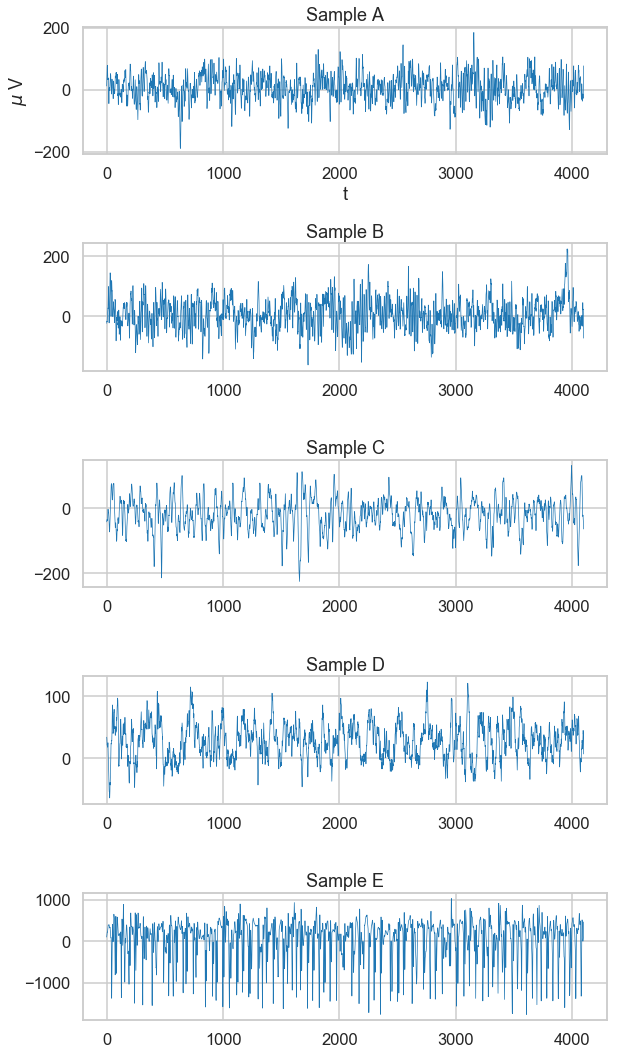

In [5]:
# Plot signals
fig,ax = plt.subplots(5,1,figsize=(9,15))

sb.set_context('talk')
sb.set_style('whitegrid')
label = ['A','B','C','D','E']

for i in range(5):
    msk = np.array(y) == i    
    ax[i].plot(X.values[msk,:][1], alpha=1, linewidth = 0.7, label=label[i])    
    ax[i].set_title('Sample '+label[i])
ax[0].set_xlabel('t')
ax[0].set_ylabel('$\mu$ V')
    
fig.tight_layout()

##### 2. CNN Model 

In [6]:
# Build a CNN class

class Net(nn.Module):
    def __init__(self, nb_class):
        super(Net,self).__init__()
        nb_hidden = 100
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(1,5), stride=3)
        self.conv2 = nn.Conv2d(16, 24, kernel_size=(1,5), stride=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(24*6, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, nb_class)
        
    def forward(self,x):
        x = F.relu(F.max_pool2d((self.conv1(x)), kernel_size=(1,3)))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), kernel_size=(1,3)))        
        x = F.relu((self.fc1(x.view(-1,24*6))))
        x = F.dropout(x,training=self.training)
        x = F.softmax(self.fc2(x), 1)        
        return x

In [173]:
   
# Define a function to obtain subsignals

def split_row(row,win_stride,win_size):
    new_set = []
    for i in range(0, row.shape[0], win_stride):
        if (i+win_size) > row.shape[0]: break
        new_set.append(row[i: i + win_size])
    tensor = Variable(Tensor(new_set).view(-1, 1, 1, win_size))
    return tensor
    
def split_rows(win_size, win_stride, data, targets):
    new_set = []
    new_targets = []
    for j,row in enumerate(data):
        for i in range(0, row.shape[0], win_stride):
            if (i + win_size) > row.shape[0]: break
            new_set.append(row[i: i + win_size])
            new_targets.append(targets[j])
    return new_set, new_targets

def ensemble_prediction(model, input_data):
    predictions = []    
    probs = model(input_data)
    proba = probs.data.mean(0)
    pred = np.argmax(proba)    
    return pred, proba[1]


def train_model(model, train_input, train_target, mini_batch_size):
    nb_epochs = 30
    eta = 1e-1
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=eta)
    avr_loss = []
    
    for e in range(nb_epochs):
        sum_loss = 0
        for batch in range(0, train_input.size(0), mini_batch_size):            
            batch_size = mini_batch_size
            if (batch + batch_size) > train_input.size(0):
                batch_size = train_input.size(0) - batch     
                
            output = model(train_input.narrow(0, batch, batch_size))
            loss = criterion(output, train_target.narrow(0, batch, batch_size))
            sum_loss += loss.data.item()
            
            model.zero_grad()
            loss.backward()
            optimizer.step()        
        avr_loss.append(sum_loss / mini_batch_size)
    return avr_loss

def compute_nb_errors(model, data_input, data_target):
  # data_target have to be a 1DTensor for Cross entropy loss
    output = model(data_input)
    _, pred = torch.max(output.data, 1)    
    acc = torch.mean((data_target.data == pred).float())
    return acc

def compute_nb_errors2(model, data_input, data_target, ratio):
  # data_target have to be a 1DTensor for Cross entropy loss   
    preds = []
    win_stride = int(ratio*512)
    win_size = 512
    for row in data_input:
        splits = split_row(row, win_stride, win_size)
        ensemble_pred, proba = ensemble_prediction(model, splits)
        preds.append(ensemble_pred)        
#     acc = np.mean(np.asarray(data_target)== np.asarray(preds))
    cm = confusion_matrix(data_target, preds)
    return cm, preds


### Evaluation

In [133]:
def compute_metrics2(ytrue, ypred):
    metrics = {'f1':f1_score, 'auc':roc_auc_score, 'acc':accuracy_score}
    dic_metrics = {}
    for key, metric in metrics.items():
        dic_metrics[key] = metric(ytrue, ypred)
    return dic_metrics

def compute_metrics(model, data_input, data_target, ratio):
  # data_target have to be a 1DTensor for Cross entropy loss   
    preds = []
    win_stride = int(ratio*512)
    win_size = 512
    for row in data_input:
        splits = split_row(row, win_stride, win_size)
        ensemble_pred, proba = ensemble_prediction(model, splits)
        preds.append(proba)        
#     acc = np.mean(np.asarray(data_target)== np.asarray(preds))
    
    compute_metrics(data_target, ypred)
    return acc, proba[]


In [174]:
def pipeline(model, partitions, win_size=512, win_stride=128, mini_batch_size=100):
    
    mean = np.mean(partitions['train'][0][:])
    std = np.std(partitions['train'][0][:])
    
    train_input = (partitions['train'][0] - mean)/std
    test_input = (partitions['test'][0] - mean)/std

    sub_train_input, sub_train_target = split_rows(win_size, win_stride, 
                                                   train_input.values, partitions['train'][1])
    sub_test_input, sub_test_target = split_rows(win_size, win_stride, 
                                                 test_input.values, partitions['test'][1])

    train_input_var = Variable(Tensor(sub_train_input).view(-1, 1, 1, win_size))
    train_target_var = Variable(Tensor(sub_train_target).long())

    loss = train_model(model, train_input_var, train_target_var, mini_batch_size)

    # Set the windowing parameters using Scheme 1
    model.train(False)
    train_cm, train_pred = compute_nb_errors2(model, train_input.values, partitions['train'][1], 0.25)
    test_cm, test_pred = compute_nb_errors2(model, test_input.values, partitions['test'][1], 0.25)

    return train_cm, test_cm, test_pred

In [171]:
# Declare a function to perfome cross validation
def cross_val(X, y, win_size=512, win_stride=128,  mini_batch_size = 100):
    
    kfold = KFold(n_splits=10, shuffle = True, random_state=100)
    
    y2 = np.asarray(y)
    count = 0
    train_accs = []
    nb_classes = len(set(y2))
    val_avg_cm = np.zeros([nb_classes, nb_classes])
    for itrain,ival in kfold.split(X.values, y2):
        print('Computing kfold ',count+1)

        #shuffle the trainig set
        msk = np.random.choice(range(len(itrain)), size=len(itrain), replace=False)
        itrain = itrain[msk]
        
        train, ytrain = X.iloc[itrain, :], y2[itrain]
        val, yval = X.iloc[ival,:], y2[ival]
        
        nb_class = len(set(y2))
        model = Net(nb_class)
        dic_partitions = {'train':(train, ytrain), 'test':(val, yval)}
        train_cm, val_cm, _ = pipeline(model, dic_partitions)                    
        val_avg_cm = val_avg_cm + val_cm 
        
#         train_accs.append(train_acc)
#         val_accs.append(val_acc)    
#         print("TrainAcc : {:.2f} ".format(train_accs[-1]))
#         print("TestAcc : {:.2f}".format(val_accs[-1]))
        count += 1
        
    print('Done\n')
    return val_avg_cm

In [140]:
def define_classes(datasets, classes):
    X, y = [], []
    for i in range(len(classes)):
        for c in classes[i]:
            X.append(datasets[c])
            y += [i]*100    
    return pd.concat(X),y

#### Case 1: Normal vs Ictal

In [142]:
# Define the desired classes from the loaded sets 
# Z and O are sets related to the normal case and S to the ictal one

classes = [['Z','O'],['S']] 
X, y = define_classes(datasets, classes) 

train_input, test_input, train_target, test_target = train_test_split(X, y, test_size = 0.3)
dic_partitions = {'train':(train_input, train_target), 'test':(test_input, test_target)}

model = Net(2)
train_acc, test_acc, test_pred = pipeline(model, dic_partitions)


In [148]:
cm = confusion_matrix(test_target, test_pred)

array([[120,   0],
       [  0,  60]])

In [181]:
# from matplotlib.ticker import MaxNLocator
# # Training a CNN model
# model = Net(2)
# train_input, train_target, test_input, test_target = data_split(X, y)

# train_input_var = Variable(Tensor(train_input).view(-1, 1, 1, win_size))
# train_target_var = Variable(Tensor(train_target).long())

# avg_loss = train_model(model, train_input_var, train_target_var, mini_batch_size)

# fig, ax = plt.subplots(1, 1, figsize=(9,6))
# ax.plot(np.arange(1, 21, dtype=np.int), avg_loss)
# ax.set_xlabel("Epoch")
# ax.set_ylabel('Average Batch Loss')
# ax.set_xlim(1,20)


# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.show()

In [164]:
# Train a CNN model applying cross-validation
val_cm = cross_val(X, y)

Computing kfold  1
Computing kfold  2
Computing kfold  3
Computing kfold  4
Computing kfold  5
Computing kfold  6
Computing kfold  7
Computing kfold  8
Computing kfold  9
Computing kfold  10
Done



In [170]:
val_cm

array([[200.,   0.],
       [  2.,  98.]])

In [145]:
# Compute the averate teste/train erro and its std

avr_train_acc, std_train_acc = np.mean(train_accs), np.std(train_accs)
avr_test_acc, std_test_acc = np.mean(test_accs), np.std(test_accs)

print("Average train accuracy: {:.2f}, std: {:.3f}".format(avr_train_acc,std_train_acc))
print("Average test accuracy: {:.2f}, std: {:.2f}".format(avr_test_acc,std_test_acc))

Average train accuracy: 0.99, std: 0.002
Average test accuracy: 1.00, std: 0.00


#### Case 2: Normal vs Interical vs Ictal

In [45]:
### Set the windowing parameters 

win_size = 512
win_stride = 128

classes = [['Z','O'],['N','F'],['S']]
X, y = define_classes(datasets, classes)

train_input, test_input, train_target, test_target = train_test_split(X, y, test_size = 0.3)
dic_partitions = {'train':(train_input, train_target), 'test':(test_input, test_target)}

model = Net(3)
train_acc, test_acc, test_pred = pipeline(model, dic_partitions)
train_acc, test_acc

(0.9285714285714286, 0.9266666666666666)

In [46]:
confusion_matrix(test_target, test_pred)

array([[56,  2,  0],
       [ 3, 60,  1],
       [ 0,  5, 23]])

In [40]:
train_accs, test_accs = cross_val(X, y)

Computing kfold  1
TrainAcc : 0.92 
TestAcc : 0.92
Computing kfold  2
TrainAcc : 0.94 
TestAcc : 0.96
Computing kfold  3
TrainAcc : 0.93 
TestAcc : 0.86
Computing kfold  4
TrainAcc : 0.94 
TestAcc : 0.96
Computing kfold  5
TrainAcc : 0.86 
TestAcc : 0.80
Computing kfold  6
TrainAcc : 0.92 
TestAcc : 0.90
Computing kfold  7
TrainAcc : 0.89 
TestAcc : 0.88
Computing kfold  8
TrainAcc : 0.90 
TestAcc : 0.90
Computing kfold  9
TrainAcc : 0.94 
TestAcc : 0.90
Computing kfold  10
TrainAcc : 0.91 
TestAcc : 0.90
Done



In [41]:
# Compute the averate teste/train erro and its std

avr_train_acc, std_train_acc = np.mean(train_accs), np.std(train_accs)
avr_test_acc, std_test_acc = np.mean(test_accs), np.std(test_accs)

print("Average train accuracy: {:.2f}, std: {:.3f}".format(avr_train_acc,std_train_acc))
print("Average test accuracy: {:.2f}, std: {:.2f}".format(avr_test_acc,std_test_acc))

Average train accuracy: 0.91, std: 0.022
Average test accuracy: 0.90, std: 0.00


### Case 3: Normal vs Preictal vs Seizure

In [116]:
import itertools
# Function to plot a crosstable
def plot_cross_table(cm, label,
                          title='Frequency Table',
                          ticks = ['0', '1'], 
                          norm=True, 
                          cmap=plt.cm.Blues,
                          fontsize=20,
                          subplot=111):
    
    if norm:
        cm = cm.astype('float')*100 / cm.sum(axis=1)[:, np.newaxis]  
        
    classes =  [str(int(x)) for x in np.arange(cm.shape[0])]

    plt.subplot(subplot)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    # Plot text 
    fmt = '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        str_ = ''
        if norm: 
            str_ = '%'
        
        
        plt.text(j, i, format(cm[i, j], fmt)+str_,
                 horizontalalignment="center",
                 fontsize=18,
                 color="white" if cm[i, j] > thresh else "black")

    # Adjustments to the plot properties
    plt.tight_layout(pad=2)
    plt.grid(False)
    plt.ylabel('Classe Verdadeira', fontsize=fontsize-2)
    plt.xlabel('Classe Predita', fontsize=fontsize-2)
    plt.title(title,fontsize=fontsize)
    plt.colorbar(fraction=0.046)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, ticks)
    plt.yticks(tick_marks, ticks)
    return True

In [175]:

classes = [['O'],['F'],['S']]
X, y = define_classes(datasets, classes)

train_input, test_input, train_target, test_target = train_test_split(X, y, test_size = 0.3)
dic_partitions = {'train':(train_input, train_target), 'test':(test_input, test_target)}

model = Net(len(classes))
train_acc, test_acc, test_pred = pipeline(model, dic_partitions)

In [178]:
val_cm = cross_val(X, y)

Computing kfold  1
Computing kfold  2
Computing kfold  3
Computing kfold  4
Computing kfold  5
Computing kfold  6
Computing kfold  7
Computing kfold  8
Computing kfold  9
Computing kfold  10
Done



True

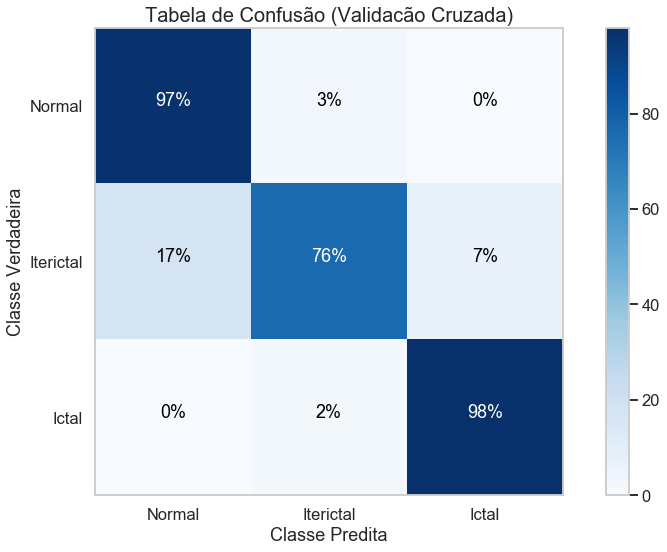

In [187]:
plt.figure(figsize = (13,8))
ticks = ['Normal', 'Iterictal', 'Ictal']
plot_cross_table(val_cm, 'tre',ticks=ticks, title='Tabela de Confusão (Validacão Cruzada)')


In [194]:
np.diag(val_cm).sum()/ np.sum(val_cm[:])

0.9033333333333333

In [201]:
val_cm.sum(axis=0) - np.diag(val_cm)

array([17.,  5.,  7.])

In [200]:
val_cm

array([[97.,  3.,  0.],
       [17., 76.,  7.],
       [ 0.,  2., 98.]])